#Enter a number, for which the sample image will be taken.

In [ ]:
userimagenumber = int(input())

40


#Show the image from the test data set:

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd 
import pickle
import os
import sklearn
import re
from scipy import ndimage, misc
import cv2
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import requests
import tarfile

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
trainimages=(x_train)
testimages=(x_test)
traincategorylabels=(y_train)
testcategorylabels=(y_test)

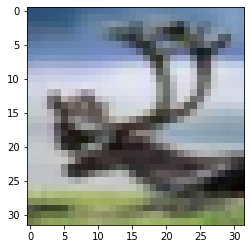

In [ ]:
plt.imshow((testimages[userimagenumber]))

In [ ]:
plt.imsave('test.png', testimages[userimagenumber])

#Sophisticated approach to create Postgres SQL Database

### Overview

This tutorial shows how to create a PostgreSQL database server.

A SQL database is an important source of data for data scientist. As one of the most popular open source SQL database, [PostgreSQL](https://www.postgresql.org) is widely used in enterprises for storing critial and transactional data across the board.

### Setup and usage

#### Install and setup PostgreSQL (optional)

**Warning: This notebook is designed to be run in a Google Colab only**. *It installs packages on the system and requires sudo access. If you want to run it in a local Jupyter notebook, please proceed with caution.*

In order to demo the usage on Google Colab you will install PostgreSQL server. The password and an empty database is also needed.

If you are not running this notebook on Google Colab, or you prefer to use an existing database, please skip the following setup and proceed to the next section.

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `tfio_demo` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS tfio_demo;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE tfio_demo;'

 * Starting PostgreSQL 10 database server
   ...done.
ALTER ROLE
DROP DATABASE
CREATE DATABASE


#### Setup necessary environmental variables

The following environmental variables are based on the PostgreSQL setup in the last section. If you have a different setup or you are using an existing database, they should be changed accordingly:


In [ ]:
%env TFIO_DEMO_DATABASE_NAME=tfio_demo
%env TFIO_DEMO_DATABASE_HOST=localhost
%env TFIO_DEMO_DATABASE_PORT=5432
%env TFIO_DEMO_DATABASE_USER=postgres
%env TFIO_DEMO_DATABASE_PASS=postgres

env: TFIO_DEMO_DATABASE_NAME=tfio_demo
env: TFIO_DEMO_DATABASE_HOST=localhost
env: TFIO_DEMO_DATABASE_PORT=5432
env: TFIO_DEMO_DATABASE_USER=postgres
env: TFIO_DEMO_DATABASE_PASS=postgres


#Train & save a model, splitted up

In [ ]:
#Train a simple deep CNN on the CIFAR10 small images dataset.
#It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
#(it's still underfitting at that point, though).



In [ ]:

batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'



In [ ]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)



Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1563/1563 [==============================] - 237s 151ms/step - loss: 2.0563 - accuracy: 0.2325 - val_loss: 1.6203 - val_accuracy: 0.4186


In [ ]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 9s 29ms/step - loss: 1.6203 - accuracy: 0.4186
Test loss: 1.6202788352966309
Test accuracy: 0.4185999929904938


#Load our trained model (.h5 model)

cv2.imshow() had to be deactivated cause it does not work on Google Colab (see also DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow)

In [ ]:
#Set Initials
import os

def set_initials():

 #set values for training specifications
 batch_size = 32
 num_classes = 10
 epochs = 1 #Defines the amount of epochs to be processed
 data_augmentation = True
 num_predictions = 20
 
 #set model name and working directory
 model_name = 'keras_cifar10_trained_model.h5'
 save_dir = os.path.join(os.getcwd(), 'saved_models')
 return batch_size, num_classes, epochs, data_augmentation, num_predictions, model_name, save_dir
 #newly added by Adrian 6.1.2021:
set_initials()

(32,
 10,
 1,
 True,
 20,
 'keras_cifar10_trained_model.h5',
 '/content/saved_models')

In [ ]:
#prep Cifar 10


import keras
from keras.datasets import cifar10

#Preparing the data
# The data, split between train and test sets

def prepare_data():
 (x_train, y_train), (x_test, y_test) = cifar10.load_data()
 print('x_train shape:', x_train.shape)
 print(x_train.shape[0], 'train samples')
 print(x_test.shape[0], 'test samples') 
 return x_train, y_train, x_test, y_test



# Convert test and training class vectors to categorical class matrices.

def data_to_categorical(y_train, y_test, num_classes):
 y_train = keras.utils.to_categorical(y_train, num_classes)
 y_test = keras.utils.to_categorical(y_test, num_classes)
 return y_train, y_test
 

In [ ]:
#test
# Source: https://gurus.pyimagesearch.com/lesson-sample-running-a-pre-trained-network/#. Import the necessary packages
from __future__ import print_function
from keras.models import load_model
from keras.datasets import cifar10
from imutils import paths
import numpy as np
import imutils
#commented out by Adrian 6.1.2021
import cv2
import os
#new addon:
from google.colab.patches import cv2_imshow
#added by Adrian 6.1.2021
from cv2 import cvtColor

def testing(model_name, save_dir, batch_size, y_test):

 # initialize the ground-truth labels for the CIFAR-10 dataset
 gtLabels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
	"ship", "truck"]
 
 # load the network
 print("[INFO] loading network architecture and weights...")
 model_path = os.path.join(save_dir, model_name)
 model = load_model(model_path)
 


In [ ]:
#load and test
from __future__ import print_function
from imutils import paths
import numpy as np
import argparse
import imutils
#commented out by Adrian 6.1.2021:
#import cv2
from cv2 import cvtColor
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


#from set_initials import set_initials
batch_size, num_classes, epochs, data_augmentation, num_predictions, model_name, save_dir = set_initials() 
print(model_name)

#from prep_cifar10 import prepare_data
x_train, y_train, x_test, y_test = prepare_data()

#from test import testing
#testing(model_name, save_dir, batch_size, y_test)

keras_cifar10_trained_model.h5
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#Make a prediction with of our sample picture

Our code adapted from Milestone 3. Test one sample and return 
1. the ndarray testData, which is the sample image
2. a string, true label test_label and 
3. another string, the predicted label pred_label

In [ ]:
def test_one(model):
 # initialize the ground-truth labels for the CIFAR-10 dataset
 gtLabels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
 
  # scale the data points into the range [0, 1]
 print("[INFO] sampling one image from CIFAR-10...")
 (testData, testLabels) = cifar10.load_data()[1] #ND Array, 50000 x 32 x 32 x 3, takes second picture out of the dataset
 testData = testData.astype("float") / 255.0
 #idxs = np.random.choice(testData.shape[0], size=(1,), replace=False)
 idxs = np.array([userimagenumber])
 print('idxs/userimagenumber & type of idxs')
 print(idxs)
 print(type(idxs))
 (testData, testLabels) = (testData[idxs], testLabels[idxs])
 testLabels = testLabels.flatten()

 # make predictions on the sample of testing data
 print("[INFO] predicting on testing data...")
 probs = model.predict(testData, batch_size=32)
 predictions = probs.argmax(axis=1)
 
 # loop over each of the testing data points
 for (i, prediction) in enumerate(predictions):
	 print("[INFO] predicted: {}, actual: {}".format(gtLabels[prediction], gtLabels[testLabels[i]]))
	
 for (i, prediction) in enumerate(predictions):
  pred_label=gtLabels[prediction]
  test_label=gtLabels[testLabels[i]] 
	 
 return testData, test_label, pred_label 


In [ ]:
testData, test_label, pred_label = test_one(model)

[INFO] sampling one image from CIFAR-10...
idxs/userimagenumber & type of idxs
[40]
<class 'numpy.ndarray'>
[INFO] predicting on testing data...
[INFO] predicted: automobile, actual: deer


#Save to Postgres Database we created in the first step with Code from Milestone3 Task3 

Based on code from Milestone 3 Task 3. Saving the prediction of a testimage.

In [ ]:
import psycopg2
import numpy as np

host = "localhost"
database = "tfio_demo"
port = "5432"
user = "postgres"
password = "postgres"

#before the changes the code was as follows:
#host = "127.0.0.1"
#database = "postgres"
#port = "5432"
#user = input("Insert a name for your database:") or "postgres"
#password = input("Insert a password for your database:") or "pgpass"


con = psycopg2.connect(dbname=database, user=user, password=password, host=host, port = port)

cur = con.cursor()

# create input data table
#cur.execute("CREATE TABLE input_data (ID SERIAL PRIMARY KEY, input_label TEXT);")

#create predictions table
#cur.execute("CREATE TABLE predictions (ID SERIAL PRIMARY KEY, prediction TEXT);")

#train the model and store it
#also make it available in this script
#import main
#model = main.model

#store test data, test label, prediction label
#from test import test_one
testData, test_label, pred_label = test_one(model)

cur.execute("CREATE TABLE input_data (ID SERIAL PRIMARY KEY, input_label varchar);")
cur.execute("CREATE TABLE predictions (ID SERIAL PRIMARY KEY, prediction varchar);")

#load testdata into database input_data
cur.execute("insert into input_data (ID, input_label) values (%s, %s)", (3, test_label) )

#load prediction into database predictions
cur.execute("insert into predictions (ID, prediction) values (%s, %s)", (3, pred_label) )



#execute query
cur.execute("select * from input_data;")
print ("These are the inputs that have been tested so far:")
print(cur.fetchall())


cur.execute("select * from predictions;")
print ("The CNN predicted the tested inputs to be:")
print(cur.fetchall())


#commit data to db
con.commit()


con.close()

[INFO] sampling one image from CIFAR-10...


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


idxs/userimagenumber & type of idxs
[40]
<class 'numpy.ndarray'>
[INFO] predicting on testing data...
[INFO] predicted: automobile, actual: deer
These are the inputs that have been tested so far:
[(3, 'deer')]
The CNN predicted the tested inputs to be:
[(3, 'automobile')]


#Prepare a Flask

Based on this tutorial: https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b and this one:
https://github.com/gstaff/flask-ngrok

In [ ]:
!pip install flask-ngrok
!pip install flask==0.12.2

In [ ]:
# flask_ngrok_example.py
from flask import Flask
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

stringuserimagenumber = str(userimagenumber)
stringpred_label = str(pred_label)
stringtest_label = str(test_label)
#image = plt.imread(test.png)

@app.route("/")
def welcome():
    output = "<h1>Welcome!</h1><br>Please enter /predict in your browser line to see an overview of the testing."
    return output
    #return image

@app.route("/predict")
def predict():
    output = "<h1>Welcome!</h1><br>Please find below an overview of the testing.<br><br>You have selected the following image number out of the CIFAR 10 test dataset: " + str(userimagenumber) + "<br><br>Please add in your browser URL '/yourimage' to see your test image, out of the CIFAR 10 test dataset." + "<br><br>The model predicted the following category of the picture: " + str(pred_label) + "<br><br>The following category is the correct one: " + str(test_label)
    return output
    #return image

from flask import send_file

@app.route('/predict/yourimage')
def get_image():
    filename = 'test.png'
    return send_file(filename, mimetype='image/png')

if __name__ == '__main__':
    app.run()

#Code below: Show everything that was done in the Flask / Browserview

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://de3b62663b00.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


In [ ]:
#the below is just some legacy code that was worked on for the last functions in github

#from flask import Flask, redirect, url_for, render_template, request
#
#app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run
#
#@app.route("/")
#def home():
#    output = "<h1>Welcome!</h1><br>Please enter /predict in your browser line to see an overview of the testing."
#    return output
#
#@app.route("/login", methods=["POST", "GET"])
#def login():
#    if request.method == "POST":
#        user = request.form["nm"]
#        return redirect(url_for("user", usr=user))
#    else:
#        output = '<form action="#" method="post"><p>Pick a number:</p><p><input type="text" name="nm" /></p><p><input type="submit" value="submit"/></p></form>'
#        return output
#
#@app.route("/<usr>")
#def user(usr):
#    return f"<h1>{usr}</h1>"
#
#if __name__ == "__main__":
#    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a89e547a8fa1.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/Jan/2021 01:32:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jan/2021 01:32:33] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [23/Jan/2021 01:32:37] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [23/Jan/2021 01:32:37] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [23/Jan/2021 01:32:39] "POST /login HTTP/1.1" 302 -
127.0.0.1 - - [23/Jan/2021 01:32:39] "GET /so HTTP/1.1" 200 -
127.0.0.1 - - [23/Jan/2021 01:32:40] "GET /favicon.ico HTTP/1.1" 200 -
